In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import jupiter_utils
import os


In [13]:
dataset_path = os.path.abspath(r'C:\DevEnv\Workspaces\facemask-maker\datasets\ds5_fake_face_mask')
args = {
    'dataset': '../datasets/ds5_fake_face_mask',
    'plot': 'plot.png',
    # 'model': 'mask_detector_inception_v3_ds_5__1.model'
    'model': 'mask_detector_mobile_net_v2_ds_5__1.model'
}

In [14]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [15]:
data = []
labels = []
with_mask_label = 'with_mask'
without_mask_label = 'without_mask'
with_mask_data_paths = jupiter_utils.get_paths_of_files_by_extension(os.path.join(dataset_path, with_mask_label), extension='jpg')
without_mask_data_paths = jupiter_utils.get_paths_of_files_by_extension(os.path.join(dataset_path, without_mask_label), extension='jpg')

# with mask
for imagePath in with_mask_data_paths:
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	data.append(image)
	labels.append(with_mask_label)

# without mask
for imagePath in without_mask_data_paths:
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	data.append(image)
	labels.append(without_mask_label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

print(f'With mask items: {len(with_mask_data_paths)}')
print(f'Without mask items: {len(without_mask_data_paths)}')

With mask items: 1000
Without mask items: 1000


In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet",
						include_top=False,
						input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

ValueError: Found array with dim 3. Estimator expected <= 2.

In [7]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [8]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
34/34 [==============================] - 50s 1s/step - loss: 0.6078 - acc: 0.6835 - val_loss: 0.2550 - val_acc: 0.9420

In [9]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [16]:
print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")



[INFO] saving mask detector model...


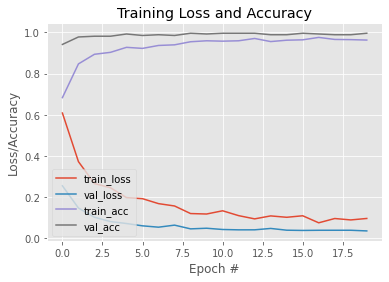

In [17]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig(args["plot"])

In [47]:
from tensorflow.keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

plot_model(model, 'C:\\DevEnv\\Workspaces\\facemask-maker\\model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [48]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [16]:
img_data_gen = ImageDataGenerator()

In [17]:
data_it = img_data_gen.flow_from_directory('../datasets/ds5_fake_face_mask/', class_mode='binary', batch_size=64)

Found 13126 images belonging to 2 classes.


In [1]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13127266982010435482
]
